Experience 3: collapse of a truncated sphere using the TREECODE


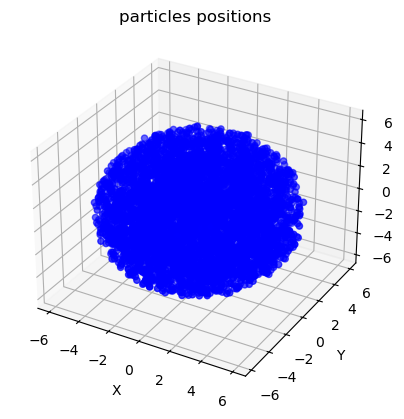

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

a=6 #radius of the sphere
N=5000 #number of particles

#sample of the radii
P=np.random.uniform(0, 1, N)
r=[]
r=a*P**(1/3)
#plt.hist(r, bins=50, density=True)
#plt.show()

#sample of phi
phi=np.random.uniform(0, 2*np.pi, N)
#plt.hist(phi, bins=50, density=True) #IS IT NORMALIZED??
#plt.title('phi distribution')
#plt.show()

#sample of theta
P1=np.random.uniform(0, 1, N)
theta=[]
for i in range(0, N):
    theta=np.append(theta, math.acos(1-2*P1[i]))
#plt.hist(theta, bins=50, density=True)
#plt.show()

x=[]
y=[]
z=[]

#conevrting the positions from spherical coords to cartesian ones (because the code works with cartesian coords)
for i in range(0, N):
    x=np.append(x, r[i]*math.sin(theta[i])*math.cos(phi[i]))
    y=np.append(y, r[i]*math.sin(theta[i])*math.sin(phi[i]))
    z=np.append(z, r[i]*math.cos(theta[i]))

#verify that the points form a sphere (of radius=a)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

'''
ax.set_xlim(2.75, 2.85)  
ax.set_ylim(-3.40, 1)  
ax.set_zlim(-2.90, -2.65)
'''
plt.title('particles positions')
plt.show()

In [2]:
starting_time=0
num_dimensions=3
m=np.ones(N) #mass of each particle in internal units (in the first example it corresponds to 1kg)
#m=[2] * N #mass of each particle is =2

#initial velocities (all the particles are at rest at the beginning)
vx=np.zeros(N)
vy=np.zeros(N)
vz=np.zeros(N)

#file for the C code
with open("Treecode5000.in", "w") as f:     
    print(N, num_dimensions, starting_time, sep="\n", file=f)
    np.savetxt(f, np.column_stack([m]), delimiter=" ")  #x, y, z, vx, vy, vz]), delimiter=" ")
    np.savetxt(f, np.column_stack([x, y, z]), delimiter=" ")
    np.savetxt(f, np.column_stack([vx, vy, vz]), delimiter=" ")

Comand: ./treecode in=Treecode5000.in out=out_tree5000_20.out dtime=0.05 eps=0.01 theta=0.1 tstop=1 dtout=0.05 > energy5000_20.log

In [2]:
#Conversion in IU
G_p = 6.67259e-8 #G in cgs
M_sun = 1.9891e33 #solar mass in g
R_sun = 6.9598e10 #solar radius in cm 
year = 3.14159e7
ly = 9.463e17 #light year in cm
parsec = 3.086e18 #parsec in cm
AU = 1.496e13 #astronomical unit in cm

def v_IU(v_p, M_p=M_sun, r_p=AU):    #because 1 M_i = 1 M_sun and 1 r_i = 1 AU
    return np.sqrt(r_p / (G_p * M_p)) * v_p

def t_IU(t_p, M_p=M_sun, r_p=AU):
    return ((t_p / r_p)*(np.sqrt((G_p * M_p)/r_p)))

t_iu_yr = 6.251839 #1 yr is 6.251839 IU
v_iu_cgs = 3.357e-7 #1 cm/s is 3.357e-7 IU

M = 5000 #Total mass in IU that corresponds to 5000 solar masses
M_i = M / N #Single particle mass, that is 1 IU

In [3]:
#Compute the dynamical time and the collapse time in years

volume = 4/3 * np.pi * a**3

density_0 = M / volume #Initial density

t_dyn_IU = np.sqrt(3 * np.pi / (16 * density_0))  #G_i=1!

t_coll_IU = t_dyn_IU / np.sqrt(2) 

t_dyn = t_dyn_IU / t_iu_yr

t_coll = t_coll_IU / t_iu_yr

#eps = 1e-4 * (volume / N)**(-1/3)
#print("Epsilon = " + str(eps))

print("Dynamical time:" + f"{t_dyn: .4f}" + " yr")
print("Dynamical time (IU):"  + f"{t_dyn_IU: .4f}") 
print("Collapse time:" + f"{t_coll: .5f}" + " yr")
print("Collapse time (IU): " + f"{t_coll_IU: .5f}")
print("Initial density (IU):" + f"{density_0: .3e}")

Dynamical time: 0.0522 yr
Dynamical time (IU): 0.3265
Collapse time: 0.03693 yr
Collapse time (IU):  0.23086
Initial density (IU): 5.526e+00


In [4]:
#per il momento sono tutti in IU
def GetData(filename, N):
    file_output = open(filename, "r")
    output = file_output.read().splitlines()
    data = []
    time = []
    
    for i in range(3, len(output), 3 * N + 3):
        for j in range(N, 3 * N):
            data.append(output[i + j].split())
        
        time.append(float(output[i - 1]))
        
    #Convert the time in years
    #time = np.array(time) / t_iu_yr
    
    file_output.close()
    
    return np.array(data), time

#Get the evolution in time from the data in the CM frame

def GetCoords(data, t, N):
    
    #Get the coordinates
    
    x_ext, y_ext, z_ext = [], [], []
    
    for i in range(0, len(t)):
        x_ext.append([])
        y_ext.append([])
        z_ext.append([])
        
    #Every row contains the coordinate of the i-th particle, every column contains its evolution in time
    
    row = 0
    
    for i in range(0, len(data), 2 * N):    
        for j in range(0, N):
            x_ext[row].append(float(data[i + j][0]))
            y_ext[row].append(float(data[i + j][1]))
            z_ext[row].append(float(data[i + j][2]))
        
        row += 1
    
    #Convert the coordinates to the CM frame
        
    x_ext = np.array(x_ext)
    y_ext = np.array(y_ext)
    z_ext = np.array(z_ext)
    
    x_CM = M_i * np.sum(x_ext, axis=1) / M   #le masse sono tutte uguali
    y_CM = M_i * np.sum(y_ext, axis=1) / M
    z_CM = M_i * np.sum(z_ext, axis=1) / M
    
    x = x_ext - x_CM[0]
    y = y_ext - y_CM[0]
    z = z_ext - z_CM[0]

    return x, y, z


#Get the velocities in time in the CM frame

def GetVelocities(data, t, N):
    
    #Get the coordinates
    
    vx_ext, vy_ext, vz_ext = [], [], []
    
    for i in range(0, len(t)):
        vx_ext.append([])
        vy_ext.append([])
        vz_ext.append([])
        
    #Every row contains the coordinate of the i-th particle, every column contains its evolution in time
    
    row = 0
    
    for i in range(N, len(data), 2 * N):    
        for j in range(0, N):
            vx_ext[row].append(float(data[i + j][0]))
            vy_ext[row].append(float(data[i + j][1]))
            vz_ext[row].append(float(data[i + j][2]))
        
        row += 1
    
    #Convert the coordinates to the CM frame
        
    vx_ext = np.array(vx_ext)
    vy_ext = np.array(vy_ext)
    vz_ext = np.array(vz_ext)
    
    vx_CM = M_i * np.sum(vx_ext, axis=1) / M
    vy_CM = M_i * np.sum(vy_ext, axis=1) / M
    vz_CM = M_i * np.sum(vz_ext, axis=1) / M
    
    K_CM = M * (vx_CM**2 + vy_CM**2 + vz_CM**2) / 2   #energia cinetica del centro di massa 
    
    vx = vx_ext - vx_CM[0]
    vy = vy_ext - vy_CM[0]
    vz = vz_ext - vz_CM[0]

    return vx, vy, vz, K_CM

In [5]:
data, t = GetData("out_tree5000_20_001.out", N)
x, y, z = GetCoords(data, t, N)
vx, vy, vz, K_CM = GetVelocities(data, t, N)

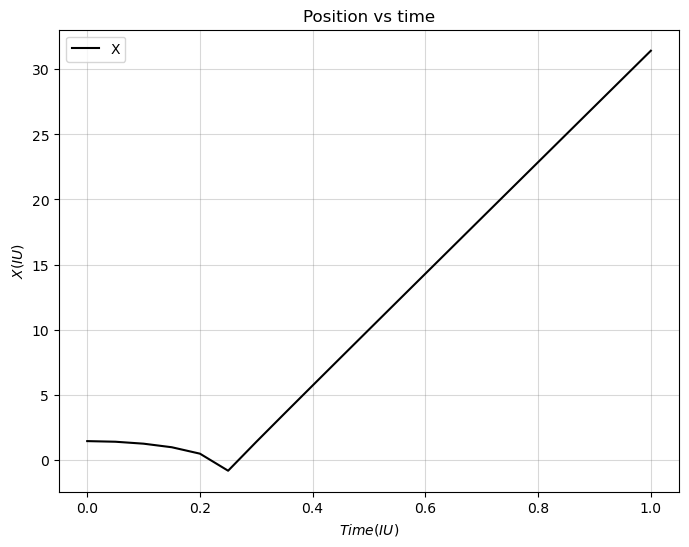

In [6]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.gca()
ax1.grid(alpha=0.3, c = 'grey')
ax1.set_xlabel('$Time (IU)$')
ax1.set_ylabel('$X (IU)$')
x_1 = np.zeros(len(t))
y_1 = np.zeros(len(t))
z_1 = np.zeros(len(t))
for i in range(len(t)):
    x_1[i] = x[i][0]
    y_1[i] = y[i][0]
    z_1[i] = z[i][0]
ax1.plot(t, x_1, label = 'X', c= 'black')
#ax1.plot(t, y_1, label = 'Y', c= 'green')
#ax1.plot(t, z_1, label = 'Z', c= 'red')
#ax1.plot(x_1, y_1)
ax1.set_title('Position vs time')
ax1.legend()


Text(0.5, 0, 'Z')

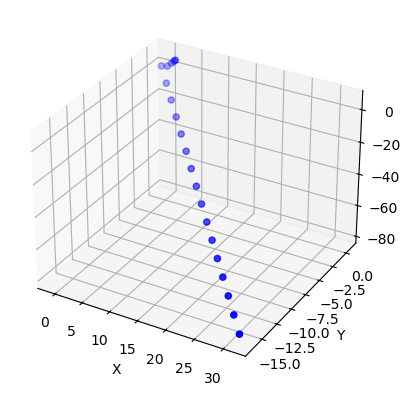

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_1, y_1, z_1, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [7]:
# We can try to compute the kinetic energy at each step 
K_i =  M_i * (vx**2 + vy**2 + vz**2) / 2

K_tot = np.zeros(len(K_i))
for i in range(len(K_i)):
    K_tot[i] = np.sum(K_i[i])

In [8]:
#Distances bt the points
dist = np.zeros(len(x))
distances = 0
for k in range(len(x)):
    print(k)
    dist[k] = 0 
    for i in range(N):
        for j in range(i + 1, N):  # Ciclo per ogni particella j, evitando duplicati
            # Calcola la distanza tra le particelle i e j al frame k
            distance = np.sqrt((x[k, i] - x[k, j])**2 + 
                               (y[k, i] - y[k, j])**2 + 
                               (z[k, i] - z[k, j])**2)
            # Verifica che la distanza sia un numero valido prima di calcolare il reciproco
            if distance != 0:  # Evita la divisione per zero
                dist[k] += 1 / distance  #

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [9]:
#Potential energies
U_tot = np.zeros(len(x))
for i in range(len(x)):
    U_tot[i] = -M_i**2*dist[i] #G_i=1

#Total energy
E_tot = U_tot+K_tot

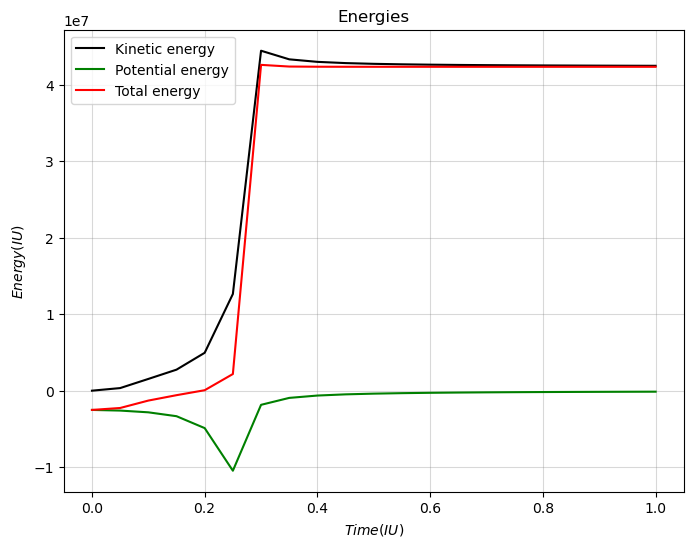

In [10]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.gca()
ax1.grid(alpha=0.3, c = 'grey')
ax1.set_xlabel('$Time(IU)$')
ax1.set_ylabel('$Energy(IU)$')
ax1.plot(t, K_tot, label = 'Kinetic energy', c= 'black')
ax1.plot(t, U_tot, label = 'Potential energy', c= 'green')
ax1.plot(t, E_tot, label = 'Total energy', c= 'red')
ax1.set_title('Energies')
ax1.legend()

In [11]:
def GetEnergy(filename, N, K_CM):
    file_output = open(filename, "r")
    output = np.array(file_output.read().splitlines())
    
    idx = np.where(output == output[9])[0] #Find the row with T and U
    
    K = []
    U = []
    
    for i in idx:
        K.append(float(output[i + 1].split()[1]))
        U.append(-float(output[i + 1].split()[2]))
        
    K = (np.array(K) - K_CM[0]) #* M_sun / v_iu_cgs**2
    U = np.array(U) #* G_p * M_sun**2 / AU

    E = K + U
    
    file_output.close()
    
    return E, K, U 
    
E, K, U = GetEnergy("energy5000_20_001.log", N, K_CM)

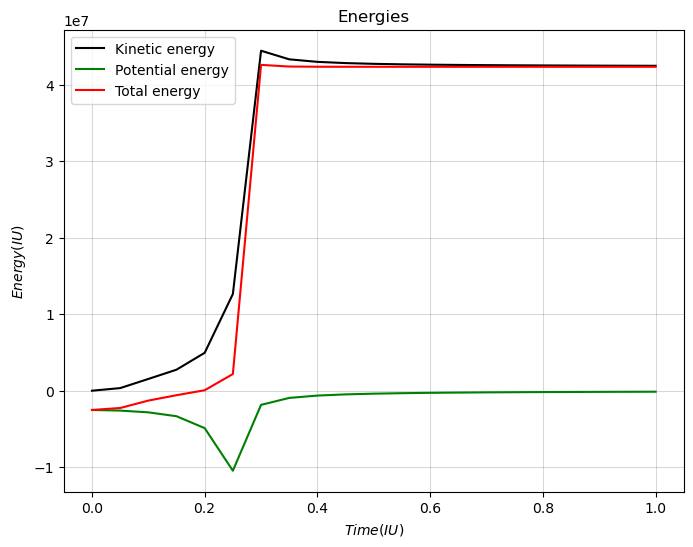

In [12]:
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.gca()
ax2.grid(alpha=0.3, c = 'grey')
ax2.set_xlabel('$Time (IU)$')
ax2.set_ylabel('$Energy (IU)$')
ax2.plot(t, K, label = 'Kinetic energy', c= 'black')
ax2.plot(t, U, label = 'Potential energy', c='green')
ax2.plot(t, E, label = 'Total energy', c='red')
ax2.set_title('Energies')
ax2.legend()

In [13]:
#Evaluate the collapse time from the potential energy minimum 
min_index = np.argmin(U)
t_coll_simulation = t[min_index]
print("Collapse time from simulation:", t_coll_simulation)

Collapse time from simulation: 0.25


In [14]:
# MOVIE MAKER
#frames = 
# Animation libraries
import os
import imageio

#------------------------------------------------------------------------

# Toggle on/off the movie maker
make_movie = True

if make_movie:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    movie_dir_path = "movie_001"
    frames_dir_path = os.path.join(movie_dir_path, "frames")
    movie_frame_name_prefix = "snapshot_img_"

    # Create folders to store the movie and its frames
    if not os.path.isdir(movie_dir_path):
        os.makedirs(frames_dir_path)
    
    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)
    
    # Empty the 'movie' folder
    for file_name in os.listdir(movie_dir_path):
        file_path = os.path.join(movie_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    #------------------------------------------------------------------------
    # GENERATING FRAMES

    #------------------------------------------------------------------------
    # Roughly estimate of the number of frames of the movie
    # Lowering it increases the step between snapshots that are considered
    N_frames = len(t)
    
    # If True, frames will be deleted after the movie has been assembled
    delete_frames = True  #se vuoi i frames metti false

    # In order to efficiently plot data with the purpose of making a movie is useful
    # to swap the axis of the array. This is not necessary, but otherwise plotting fucntions
    # would take a lot of time to run
    # "new_pos" works like this: new_pos[time_index][coordinate_index][particle_index]
    # So basically new_pos[time_index][coordinate_index] gives the values of the specified
    # coordinate at the specified time for all particles
    #new_pos = np.swapaxes(pos, 0, 1) # Swap particle and time
    #new_pos = np.swapaxes(new_pos, 1, 2) # Swap particle and coordinate

    # Initialize a list to store the colors of each particle at any time
    particles_colors = []

    #color_inside = 'blue'
    #color_outside = 'orange'

    # Fill the particles_color list
    #for time_index in range(len(snapshots)):
    #    particles_colors.append([color_inside if is_inside else color_outside
    #                             for is_inside in is_particle_inside_boundary[time_index]])

    #-------------------------------------------------------------------------
    # Initialize a 3D plot
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

    # For every snapshot (or for some of them depending of the step of the range() call)
    # plot the positon of every particle in 3D space
    
    for i in range(12):
        for j in range(N):
            ax.scatter(x[i][j], y[i][j], z[i][j], color="blue")
            #ax.scatter(cm_pos[time_index][0], cm_pos[time_index][1], cm_pos[time_index][2], color='red')

        # For the first snapshot register the axes limit
        if i == 0:
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            z_lim = ax.get_zlim()
        
        # Set e cubic plot for every snapshot and fix the axes limit to the initial ones
        ax.set_aspect('equal', 'datalim')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)

        # Set the snapshot time stamp as the title of every plot
        #ax.set_title("$t=$" + str(round(time_stamp[time_index], 2)))
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")

        # Save the current figure with a proper name
        # zfill() is needed to achieve alphanumerical order later
        frame_name = movie_frame_name_prefix + str(i).zfill(5) + ".png"
        frame_path = os.path.join(frames_dir_path, frame_name)
        fig.savefig(frame_path)

        # Clear the axes for the next plot
        ax.clear()

    # Don't show anything
    plt.close()

    #--------------------------------------------------------------------
    # ASSEMBLING FRAMES

    #--------------------------------------------------------------------
    # Get all the files in the frames directory and sort them in alphanumerical order
    movie_img_files = os.listdir(frames_dir_path)
    movie_img_files = sorted(movie_img_files)

    movie_path = os.path.join(movie_dir_path, "movie.mp4")

    # Use the imageio writer to build the movie by appending to it every frame
    # Default fps is 10
    with imageio.get_writer(movie_path, mode='I', fps=10) as writer:
        for filename in movie_img_files:
            image = imageio.imread(os.path.join(frames_dir_path, filename)) # Get the frame
            writer.append_data(image) # Append the frame
    
    # Delete individual frames if requested
    if delete_frames:
        for file_name in os.listdir(frames_dir_path):
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)

C:\Users\ISAFA\AppData\Local\Temp\ipykernel_3256\1198253126.py:125: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(frames_dir_path, filename)) # Get the frame
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
